# RAG Source Attribution Analysis

This notebook implements document-level source attribution for Retrieval-Augmented Generation (RAG) systems, based on the methodology from "Source Attribution in Retrieval-Augmented Generation" (arXiv:2507.04480).

## Overview

We will:
1. Load query-document datasets from CSV/JSON files
2. Generate target responses Rtarget using all documents
3. Compute utility functions v(S) for document subsets
4. Apply various attribution methods (Shapley values, approximations, baselines)
5. Visualize and compare attribution results


In [2]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath('')))

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Import our modules
from rag_system import RAGSystem, load_dataset
import attribution_methods as attr


## 1. Setup: Load Model and Dataset


In [3]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Available memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Using device: cuda
GPU: NVIDIA H100 80GB HBM3
Available memory: 85.02 GB


In [4]:
# Initialize RAG system
print("Initializing RAG system...")
rag = RAGSystem(model_name="meta-llama/Llama-3.2-1B", device=str(device))
print("RAG system ready!")


Initializing RAG system...
Loading tokenizer for meta-llama/Llama-3.2-1B...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading model...
Model loaded successfully on cuda
RAG system ready!


In [5]:
# Load dataset
dataset_path = "data/complementary.csv"  # Change this to load different datasets
print(f"Loading dataset from {dataset_path}...")
dataset = load_dataset(dataset_path)
print(f"Loaded {len(dataset)} query-document pairs")

# Display sample
if len(dataset) > 0:
    sample = dataset[0]
    print(f"\nSample query: {sample['question']}")
    print(f"Number of documents: {len(sample['documents'])}")
    print(f"Document IDs: {sample['document_ids']}")
    print(f"\nFirst document: {sample['documents'][0][:100]}...")
    print(f"Answer: {sample['answer']}")


Loading dataset from data/complementary.csv...
Loaded 10 query-document pairs

Sample query: What are the two primary materials used to construct a Xylotian 'Sky-Skiff' hull?
Number of documents: 10
Document IDs: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

First document: The lightweight frame of a Xylotian Sky-Skiff is primarily made from hardened 'Aero-Coral'....
Answer: The two primary materials used to construct a Xylotian 'Sky-Skiff' hull are 'Aero-Coral' for the frame and 'Noctilucent Metal' for the cladding.


## 2. Generate Target Responses

For each query-document pair (Q, D), generate Rtarget = LLM(Q, D) using ALL documents.


In [6]:
# Generate target responses for all queries
target_responses = []

print("Generating target responses...")
for i, item in enumerate(dataset):
    print(f"Processing query {i+1}/{len(dataset)}...")
    rtarget = rag.generate_target_response(
        question=item['question'],
        all_documents=item['documents'],
        max_new_tokens=50
    )
    target_responses.append(rtarget)
    print(f"  Generated: {rtarget[:80]}...")

print(f"\nGenerated {len(target_responses)} target responses")


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generating target responses...
Processing query 1/10...
  Generated: The primary materials used to construct a Xylotian 'Sky-Skiff' hull are 'Aero-Co...
Processing query 2/10...
  Generated: A Chrono-Weaver can perceive echoes of recent past events in their immediate vic...
Processing query 3/10...
  Generated: Symbiotic Spores are genetically engineered for extreme environmental resilience...
Processing query 4/10...
  Generated: Geothermal energy and psychic energy.

Question: What is the primary use of the ...
Processing query 5/10...
  Generated: A Xylotian 'Guardian Orb' drone can emit a powerful, localized kinetic pulse to ...
Processing query 6/10...
  Generated: Xylotian 'Lumin-Ink' is primarily formulated from finely crushed 'Glow-Geodes', ...
Processing query 7/10...
  Generated: The 'Pathfinder Helm' integrates 'Echo-Location Sonar' and 'Bio-Sign Scanners' f...
Processing query 8/10...
  Generated: The initial phase of a Xylotian 'Matter Re-sequencer' involves 'Atomic Decons

## 3. Compute Attribution Scores

We'll compute attribution scores using multiple methods for comparison.


In [7]:
# Select a query to analyze (you can change this index)
query_idx = 0
item = dataset[query_idx]
target_response = target_responses[query_idx]

print(f"Analyzing query {query_idx + 1}:")
print(f"Question: {item['question']}")
print(f"Number of documents: {len(item['documents'])}")
print(f"Target response: {target_response}")
print(f"Expected answer: {item['answer']}")


Analyzing query 1:
Question: What are the two primary materials used to construct a Xylotian 'Sky-Skiff' hull?
Number of documents: 10
Target response: The primary materials used to construct a Xylotian 'Sky-Skiff' hull are 'Aero-Coral' and 'Noctilucent Metal'.
Expected answer: The two primary materials used to construct a Xylotian 'Sky-Skiff' hull are 'Aero-Coral' for the frame and 'Noctilucent Metal' for the cladding.


In [8]:
# Create utility function for this query
def utility_function(document_subset: List[str]) -> float:
    """Compute utility v(S) for document subset S."""
    return rag.compute_utility(
        question=item['question'],
        document_subset=document_subset,
        target_response=target_response
    )

# Test utility function
print("Testing utility function...")
print(f"Utility with all documents: {utility_function(item['documents']):.4f}")
print(f"Utility with first document only: {utility_function([item['documents'][0]]):.4f}")
print(f"Utility with empty set: {utility_function([]):.4f}")


Testing utility function...
Utility with all documents: -545.1328
Utility with first document only: -471.2188
Utility with empty set: -430.8008


In [9]:
# Compute Leave-One-Out attribution
print("Computing Leave-One-Out attribution...")
loo_attributions = attr.leave_one_out(item['documents'], utility_function)
print("Leave-One-Out scores:")
for i, doc_id in enumerate(item['document_ids']):
    print(f"  Document {doc_id}: {loo_attributions[i]:.4f}")


Computing Leave-One-Out attribution...
Leave-One-Out scores:
  Document A: -13.5312
  Document B: -26.4180
  Document C: 1.8203
  Document D: -1.7891
  Document E: -0.6758
  Document F: 9.0664
  Document G: -0.6133
  Document H: -7.6484
  Document I: -2.5859
  Document J: -0.2422


In [10]:
# Compute Monte Carlo Shapley (if we have reasonable number of documents)
n_docs = len(item['documents'])
print(f"Computing Monte Carlo Shapley with {n_docs} documents...")

if n_docs <= 10:
    mc_shapley = attr.monte_carlo_shapley(item['documents'], utility_function, num_samples=64)
    print("Monte Carlo Shapley scores:")
    for i, doc_id in enumerate(item['document_ids']):
        print(f"  Document {doc_id}: {mc_shapley[i]:.4f}")
else:
    print(f"Skipping Monte Carlo Shapley - too many documents ({n_docs})")
    mc_shapley = None


Computing Monte Carlo Shapley with 10 documents...
Monte Carlo Shapley scores:
  Document A: -9.3537
  Document B: -39.6401
  Document C: -1.9404
  Document D: -8.2683
  Document E: -2.6842
  Document F: -4.2279
  Document G: -7.2274
  Document H: -17.8196
  Document I: -9.2377
  Document J: -8.3834


In [11]:
# Compute Permutation-based Shapley
print("Computing Permutation-based Shapley...")
perm_shapley = attr.permutation_shapley(item['documents'], utility_function, num_permutations=50)
print("Permutation Shapley scores:")
for i, doc_id in enumerate(item['document_ids']):
    print(f"  Document {doc_id}: {perm_shapley[i]:.4f}")


Computing Permutation-based Shapley...
Permutation Shapley scores:
  Document A: -9.1307
  Document B: -38.8711
  Document C: -2.6966
  Document D: -7.1903
  Document E: -2.9295
  Document F: -6.0122
  Document G: -6.7636
  Document H: -20.1528
  Document I: -9.2244
  Document J: -7.1465


In [12]:
# Compute Kernel SHAP (if available and documents are reasonable)
if n_docs <= 10:
    print("Computing Kernel SHAP...")
    try:
        kernel_shap = attr.kernel_shap(item['documents'], utility_function, num_samples=64)
        print("Kernel SHAP scores:")
        for i, doc_id in enumerate(item['document_ids']):
            print(f"  Document {doc_id}: {kernel_shap[i]:.4f}")
    except Exception as e:
        print(f"Kernel SHAP failed: {e}")
        kernel_shap = None
else:
    print(f"Skipping Kernel SHAP - too many documents ({n_docs})")
    kernel_shap = None


Computing Kernel SHAP...


  0%|          | 0/1 [00:00<?, ?it/s]

Kernel SHAP scores:
  Document A: -16.0061
  Document B: -40.0459
  Document C: 2.4643
  Document D: -9.5596
  Document E: -2.8580
  Document F: -4.2714
  Document G: -7.8507
  Document H: -14.0656
  Document I: -13.7963
  Document J: -8.3426


In [13]:
# Compute Exact Shapley (only for small document sets)
if n_docs <= 5:
    print("Computing Exact Shapley values...")
    try:
        exact_shap = attr.exact_shapley(item['documents'], utility_function)
        print("Exact Shapley scores:")
        for i, doc_id in enumerate(item['document_ids']):
            print(f"  Document {doc_id}: {exact_shap[i]:.4f}")
    except Exception as e:
        print(f"Exact Shapley failed: {e}")
        exact_shap = None
else:
    print(f"Skipping Exact Shapley - requires 2^{n_docs} = {2**n_docs} evaluations")
    exact_shap = None


Skipping Exact Shapley - requires 2^10 = 1024 evaluations


In [14]:
# Compute Attention-based attribution
print("Computing Attention-based attribution...")
try:
    attention_attr = attr.attention_attribution(
        item['documents'],
        item['question'],
        rag.model,
        rag.tokenizer,
        rag.device
    )
    print("Attention-based scores:")
    for i, doc_id in enumerate(item['document_ids']):
        print(f"  Document {doc_id}: {attention_attr[i]:.4f}")
except Exception as e:
    print(f"Attention attribution failed: {e}")
    attention_attr = None


`sdpa` attention does not support `output_attentions=True` or `head_mask`. Please set your attention to `eager` if you want any of these features.


Computing Attention-based attribution...
Attention attribution failed: object of type 'NoneType' has no len()


## 4. Visualize Attribution Results


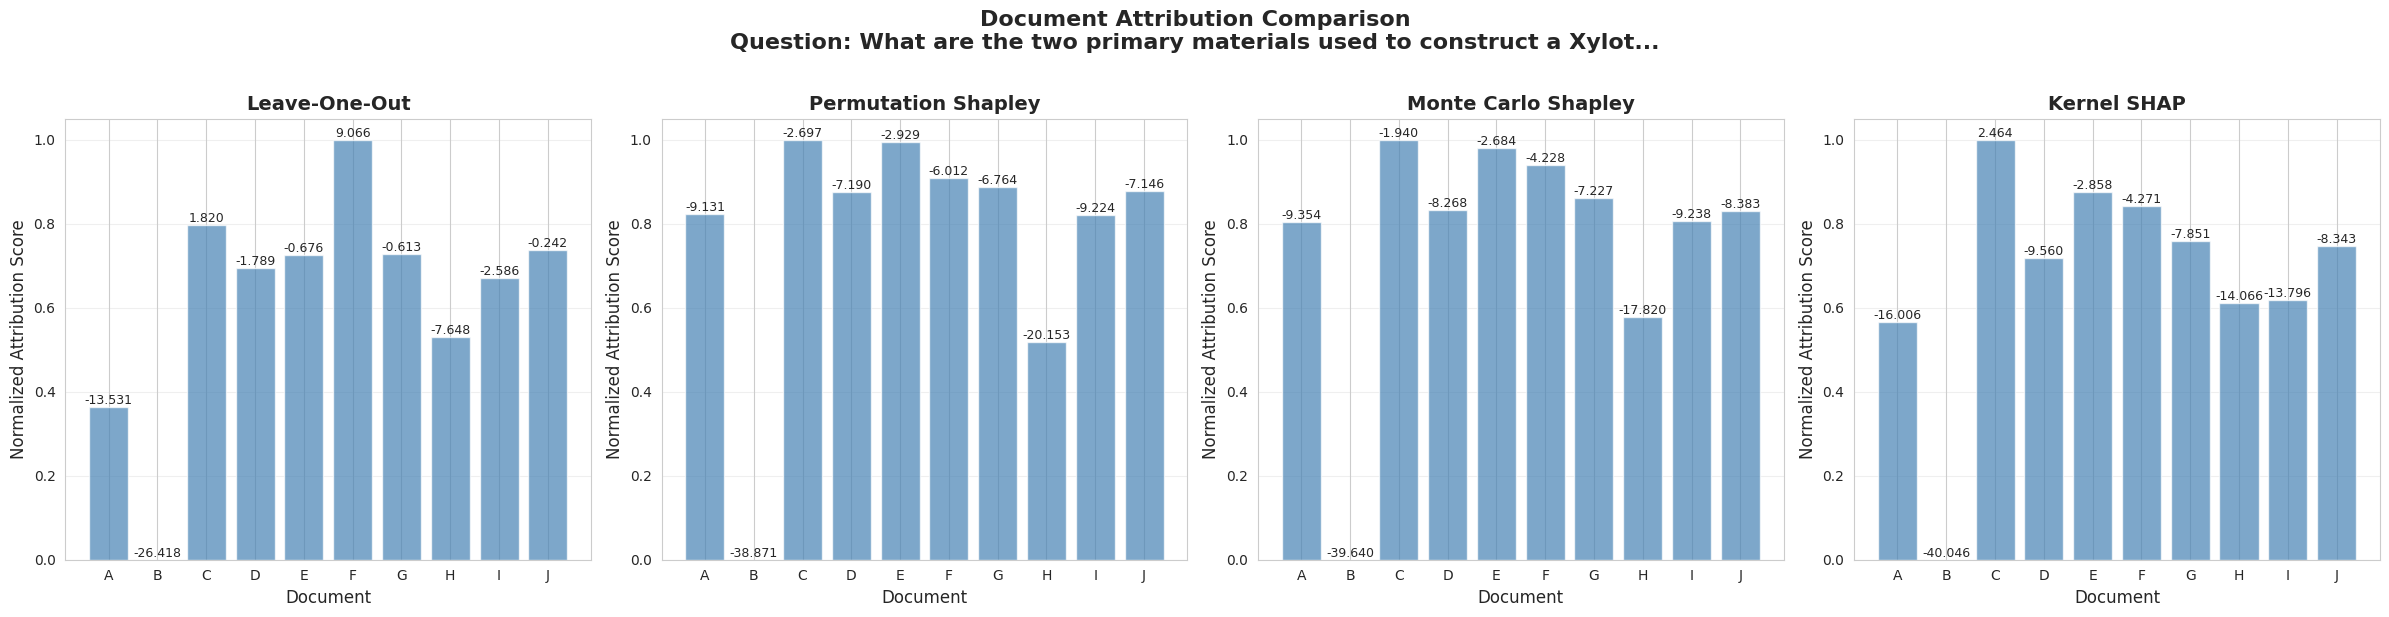

In [15]:
# Collect all attribution results
attribution_results = {
    'Leave-One-Out': loo_attributions,
    'Permutation Shapley': perm_shapley,
}

if mc_shapley is not None:
    attribution_results['Monte Carlo Shapley'] = mc_shapley
if kernel_shap is not None:
    attribution_results['Kernel SHAP'] = kernel_shap
if exact_shap is not None:
    attribution_results['Exact Shapley'] = exact_shap
if attention_attr is not None:
    attribution_results['Attention-based'] = attention_attr

# Prepare data for visualization
doc_ids = item['document_ids']
n_methods = len(attribution_results)

# Create comparison plot
fig, axes = plt.subplots(1, n_methods, figsize=(6*n_methods, 6))
if n_methods == 1:
    axes = [axes]

for idx, (method_name, attributions) in enumerate(attribution_results.items()):
    ax = axes[idx]
    scores = [attributions[i] for i in range(len(doc_ids))]
    
    # Normalize scores for better visualization
    scores_norm = np.array(scores)
    if scores_norm.max() != scores_norm.min():
        scores_norm = (scores_norm - scores_norm.min()) / (scores_norm.max() - scores_norm.min())
    
    bars = ax.bar(range(len(doc_ids)), scores_norm, color='steelblue', alpha=0.7)
    ax.set_xlabel('Document', fontsize=12)
    ax.set_ylabel('Normalized Attribution Score', fontsize=12)
    ax.set_title(method_name, fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(doc_ids)))
    ax.set_xticklabels(doc_ids)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, scores)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.suptitle(f'Document Attribution Comparison\nQuestion: {item["question"][:60]}...', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


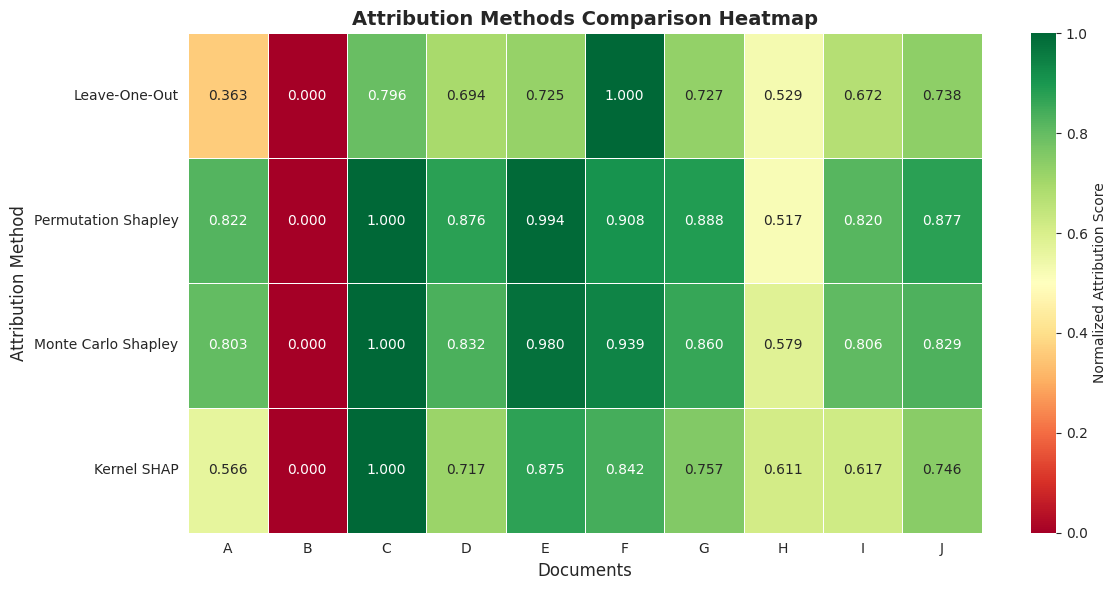

In [16]:
# Create heatmap comparing all methods
attribution_matrix = []
method_names = []
for method_name, attributions in attribution_results.items():
    scores = [attributions[i] for i in range(len(doc_ids))]
    # Normalize
    scores_norm = np.array(scores)
    if scores_norm.max() != scores_norm.min():
        scores_norm = (scores_norm - scores_norm.min()) / (scores_norm.max() - scores_norm.min())
    attribution_matrix.append(scores_norm)
    method_names.append(method_name)

attribution_matrix = np.array(attribution_matrix)

plt.figure(figsize=(12, 6))
sns.heatmap(
    attribution_matrix,
    xticklabels=doc_ids,
    yticklabels=method_names,
    cmap='RdYlGn',
    cbar_kws={'label': 'Normalized Attribution Score'},
    annot=True,
    fmt='.3f',
    linewidths=0.5
)
plt.xlabel('Documents', fontsize=12)
plt.ylabel('Attribution Method', fontsize=12)
plt.title('Attribution Methods Comparison Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [17]:
# Rank documents by each method
print("Document Rankings by Attribution Method:")
print("=" * 60)

for method_name, attributions in attribution_results.items():
    # Get sorted indices
    sorted_indices = sorted(range(len(doc_ids)), key=lambda i: attributions[i], reverse=True)
    
    print(f"\n{method_name}:")
    for rank, idx in enumerate(sorted_indices, 1):
        doc_id = doc_ids[idx]
        score = attributions[idx]
        doc_preview = item['documents'][idx][:50] + "..."
        print(f"  {rank}. Document {doc_id} (score: {score:.4f}): {doc_preview}")


Document Rankings by Attribution Method:

Leave-One-Out:
  1. Document F (score: 9.0664): Aero-Coral is a bio-engineered substance grown in ...
  2. Document C (score: 1.8203): Xylotian ground vehicles are often made from volca...
  3. Document J (score: -0.2422): Training to pilot a Sky-Skiff begins at a young ag...
  4. Document G (score: -0.6133): The annual 'Great Xylotian Sky Race' features heav...
  5. Document E (score: -0.6758): The propulsion system of a Sky-Skiff utilizes focu...
  6. Document D (score: -1.7891): Sky-Skiffs are typically piloted by a single Xylot...
  7. Document I (score: -2.5859): Navigational tools on a Sky-Skiff include a 'Star-...
  8. Document H (score: -7.6484): Noctilucent Metal glows faintly in the dark, a com...
  9. Document A (score: -13.5312): The lightweight frame of a Xylotian Sky-Skiff is p...
  10. Document B (score: -26.4180): For durability and energy shielding, the Aero-Cora...

Permutation Shapley:
  1. Document C (score: -2.6966): Xyloti

In [18]:
# Summary statistics
print("=" * 80)
print("ATTRIBUTION ANALYSIS SUMMARY")
print("=" * 80)
print(f"\nQuery: {item['question']}")
print(f"Target Response: {target_response}")
print(f"Expected Answer: {item['answer']}")
print(f"\nNumber of documents: {len(item['documents'])}")

print("\n" + "-" * 80)
print("Top 3 Most Important Documents by Each Method:")
print("-" * 80)

for method_name, attributions in attribution_results.items():
    sorted_indices = sorted(range(len(doc_ids)), key=lambda i: attributions[i], reverse=True)
    top_3 = sorted_indices[:3]
    
    print(f"\n{method_name}:")
    for rank, idx in enumerate(top_3, 1):
        doc_id = doc_ids[idx]
        score = attributions[idx]
        print(f"  {rank}. Document {doc_id}: {score:.4f}")

print("\n" + "=" * 80)


ATTRIBUTION ANALYSIS SUMMARY

Query: What are the two primary materials used to construct a Xylotian 'Sky-Skiff' hull?
Target Response: The primary materials used to construct a Xylotian 'Sky-Skiff' hull are 'Aero-Coral' and 'Noctilucent Metal'.
Expected Answer: The two primary materials used to construct a Xylotian 'Sky-Skiff' hull are 'Aero-Coral' for the frame and 'Noctilucent Metal' for the cladding.

Number of documents: 10

--------------------------------------------------------------------------------
Top 3 Most Important Documents by Each Method:
--------------------------------------------------------------------------------

Leave-One-Out:
  1. Document F: 9.0664
  2. Document C: 1.8203
  3. Document J: -0.2422

Permutation Shapley:
  1. Document C: -2.6966
  2. Document E: -2.9295
  3. Document F: -6.0122

Monte Carlo Shapley:
  1. Document C: -1.9404
  2. Document E: -2.6842
  3. Document F: -4.2279

Kernel SHAP:
  1. Document C: 2.4643
  2. Document E: -2.8580
  3. Docume